ASSIGNMENT 1:
SHAHID GULZAR PADDER,
XPXSKK


Importing important libraries

In [1]:
import os, random
import cv2, dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.utils import np_utils
import random
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from sklearn.metrics import confusion_matrix, classification_report
import itertools

Importing data from the provided link

In [2]:
link = "http://nipg1.inf.elte.hu:8765/fer2013.csv"
mydata = pd.read_csv(link)

Understanding the Data and Preprocessing

In [3]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [4]:
mydata.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
mydata.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [6]:
mydata.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
%matplotlib inline
ems = pd.DataFrame({'ems': mydata.emotion})

Histogram showing emotion count respectively

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4696eeed10>]],
      dtype=object)

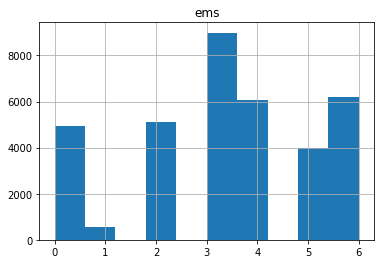

In [8]:
ems.hist()

In [9]:
def image_converting(row):
    pixl = row['pixels']
    im = np.array(pixl.split())
    im = im.reshape(48,48)
    img = np.zeros((48,48,3)) 
    img[:,:,0] = im
    img[:,:,1] = im
    img[:,:,2] = im
    return img.astype(np.uint8)

In [10]:
count = 0
imag = []

for i in range(1, 10): 
    faces = mydata.iloc[i]
    img = image_converting(faces) 
    count = count + 1  
    imag.append(img)

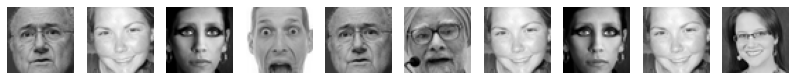

In [11]:
selected = np.random.choice(len(imag), 10)

plt.figure(figsize=(14, 5))
for i, ind in enumerate(selected):
  plt.subplot(2, 10, i+1)
  plt.imshow(imag[ind][..., ::-1])
  plt.axis('off')

Train Test split

In [12]:
trainset = mydata[(mydata.Usage == 'Training')] 
Xtrain = np.array(list(map(str.split, trainset.pixels)), np.float32)
Xtrain = Xtrain.reshape(Xtrain.shape[0], 48, 48, 1)
print("Xtrain:",Xtrain.shape)

Xtrain: (28709, 48, 48, 1)


In [13]:
valset = mydata[(mydata.Usage == 'PublicTest')]
Xval = np.array(list(map(str.split, valset.pixels)), np.float32) 
Xval = Xval.reshape(Xval.shape[0], 48, 48, 1)
print("Xval:",Xval.shape)

Xval: (3589, 48, 48, 1)


In [14]:
testset = mydata[(mydata.Usage == 'PrivateTest')] 
Xtest = np.array(list(map(str.split, testset.pixels)), np.float32)
Xtest = Xtest.reshape(Xtest.shape[0], 48, 48, 1)
print("Xtest:",Xtest.shape)

Xtest: (3589, 48, 48, 1)


Creating a Model

In [15]:
n_classes = 7

ytrain = trainset.emotion 
ytrain = np_utils.to_categorical(ytrain, n_classes)
print("Ytrain:",ytrain.shape)
yval = valset.emotion 
yval = np_utils.to_categorical(yval, n_classes)
print("Yval:",yval.shape)
ytest = testset.emotion 
ytest = np_utils.to_categorical(ytest, n_classes)
print("Ytest:",ytest.shape)

Ytrain: (28709, 7)
Yval: (3589, 7)
Ytest: (3589, 7)


In [16]:
datag = ImageDataGenerator(rescale=1./255,
                             rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True)

testg = ImageDataGenerator(rescale=1./255)

datag.fit(Xtrain)
batch_size = 64

In [17]:
train_flow = datag.flow(Xtrain, ytrain, batch_size=batch_size) 
val_flow = testg.flow(Xval, yval, batch_size=batch_size) 
test_flow = testg.flow(Xtest, ytest, batch_size=batch_size)

Model Summary

In [18]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D

input_shape = (48, 48, 1)

model = Sequential()

model.add(Conv2D(filters=64,input_shape=(input_shape),kernel_size=(3,3),padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.6))

#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=n_classes, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

Compiling the model

In [19]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Train the model

In [22]:
n_epochs = 40
hist = model.fit(train_flow, 
                    steps_per_epoch=len(Xtrain) // batch_size, 
                    epochs=n_epochs,  
                    verbose=1,  
                    validation_data=val_flow,  
                    validation_steps=len(Xval) // batch_size)

Epoch 1/40
448/448 [==============================] - 100s 148ms/step - loss: 2.0279 - accuracy: 0.2099 - val_loss: 1.8275 - val_accuracy: 0.2497
Epoch 2/40
448/448 [==============================] - 64s 144ms/step - loss: 1.8188 - accuracy: 0.2407 - val_loss: 1.7943 - val_accuracy: 0.2492
Epoch 3/40
448/448 [==============================] - 64s 143ms/step - loss: 1.7902 - accuracy: 0.2553 - val_loss: 1.7474 - val_accuracy: 0.2852
Epoch 4/40
448/448 [==============================] - 65s 144ms/step - loss: 1.7500 - accuracy: 0.2817 - val_loss: 1.7893 - val_accuracy: 0.2776
Epoch 5/40
448/448 [==============================] - 64s 143ms/step - loss: 1.6790 - accuracy: 0.3182 - val_loss: 1.6575 - val_accuracy: 0.3624
Epoch 6/40
448/448 [==============================] - 64s 143ms/step - loss: 1.5503 - accuracy: 0.3890 - val_loss: 1.3745 - val_accuracy: 0.4542
Epoch 7/40
448/448 [==============================] - 64s 143ms/step - loss: 1.4673 - accuracy: 0.4215 - val_loss: 1.3715 - val_a

Visualise Training and Validation Accuracies/Loss

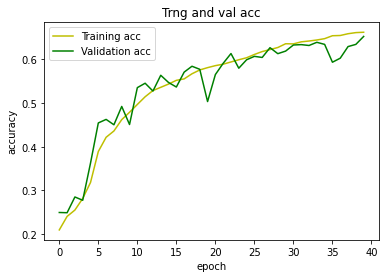

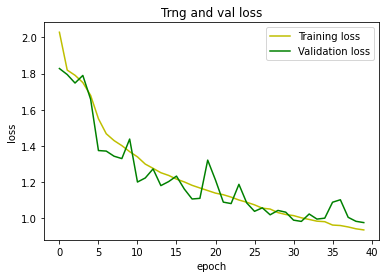

In [27]:
acuracy = hist.history['accuracy']
val_acuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
n_epochs = range(len(acuracy))
plt.plot(n_epochs, acuracy, 'y', label='Training acc')
plt.plot(n_epochs, val_acuracy, 'g', label='Validation acc')
plt.title('Trng and val acc')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(n_epochs, loss, 'y', label='Training loss')
plt.plot(n_epochs, val_loss, 'g', label='Validation loss')
plt.title('Trng and val loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [28]:
trng_loss = model.evaluate(train_flow, steps=len(Xtrain) / batch_size) 
print("Train Loss " + str(trng_loss[0]))
print("Train Acc: " + str(trng_loss[1]))
val_loss = model.evaluate(val_flow, steps=len(Xval) / batch_size) 
print("Val Loss " + str(val_loss[0]))
print("Val Acc: " + str(val_loss[1]))
test_loss = model.evaluate(test_flow, steps=len(Xtest) / batch_size) 
print("Test Loss " + str(test_loss[0]))
print("Test Acc: " + str(test_loss[1]))

448/448 [==============================] - 25s 55ms/step - loss: 0.8674 - accuracy: 0.6817
Train Loss 0.8674246072769165
Train Acc: 0.6816677451133728
56/56 [==============================] - 3s 51ms/step - loss: 0.9767 - accuracy: 0.6517
Val Loss 0.9766952395439148
Val Acc: 0.6517135500907898
56/56 [==============================] - 3s 45ms/step - loss: 0.9244 - accuracy: 0.6573
Test Loss 0.924409031867981
Test Acc: 0.6572861671447754


In [31]:
def plt_con_mat(ytest, ypred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(ytest, ypred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)

    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

In [32]:
ypred_ = model.predict(Xtest/255., verbose=1)
ypred = np.argmax(ypred, axis=1)
t_te = np.argmax(ytest, axis=1)

113/113 [==============================] - 3s 25ms/step


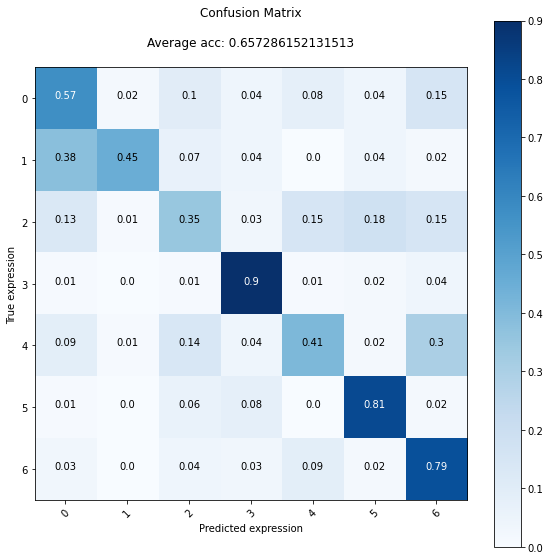

In [37]:
labels = np.array(("0", "1", "2", "3", "4", "5", "6"))

fig = plt_con_mat(ytest=t_te, ypred=ypred,
                      classes=labels,
                      normalize=True,
                      cmap=plt.cm.Blues,
                      title='Confusion Matrix'+'\n\n'+'Average acc: ' + str(np.sum(ypred == t_te)/len(t_te)) + '\n')

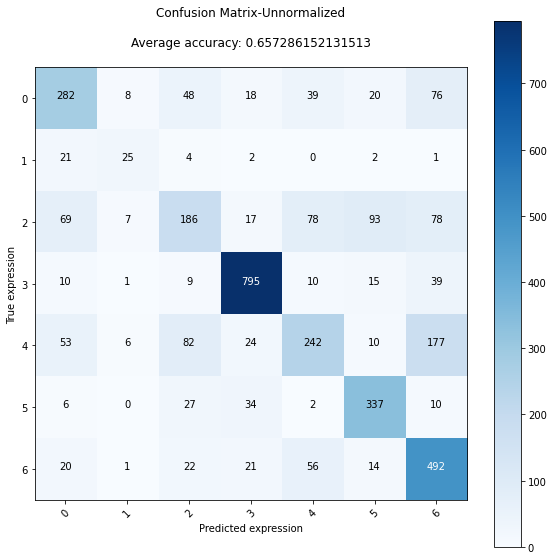

In [39]:
fig = plt_con_mat(ytest=t_te, ypred=ypred,
                      classes=labels,
                      normalize=False,
                      cmap=plt.cm.Blues,
                      title='Confusion Matrix-Unnormalized'+'\n\n'+'Average accuracy: ' + str(np.sum(ypred == t_te)/len(t_te)) + '\n')

In [41]:
print(classification_report(t_te, ypred))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       491
           1       0.52      0.45      0.49        55
           2       0.49      0.35      0.41       528
           3       0.87      0.90      0.89       879
           4       0.57      0.41      0.47       594
           5       0.69      0.81      0.74       416
           6       0.56      0.79      0.66       626

    accuracy                           0.66      3589
   macro avg       0.62      0.61      0.61      3589
weighted avg       0.65      0.66      0.65      3589



In [42]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [45]:
Xuse = np.array(list(map(str.split, trainset.pixels)), np.float32)
yuse = trainset.emotion
Xover, yover = undersample.fit_resample(Xuse, yuse)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [47]:
Xover = Xover.reshape(Xover.shape[0], 48, 48, 1)
print("Xover",Xover.shape)
yover = np_utils.to_categorical(yover, n_classes)
print("Yover:",yover.shape)

Xover (21930, 48, 48, 1)
Yover: (21930, 7)


In [49]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True)

testgen = ImageDataGenerator(rescale=1./255)

datagen.fit(Xover)
batch_size = 64

In [50]:
train_flow = datagen.flow(Xover, yover, batch_size=batch_size) 
val_flow = testgen.flow(Xval, yval, batch_size=batch_size) 
test_flow = testgen.flow(Xtest, ytest, batch_size=batch_size)

In [52]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D

input_shape = (48, 48, 1)

model = Sequential()

model.add(Conv2D(filters=64,input_shape=(input_shape),kernel_size=(3,3),padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.6))

#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=n_classes, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_26 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_27 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 128)      

In [53]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [54]:
n_epochs = 40
history = model.fit(train_flow, 
                    steps_per_epoch=len(Xover) // batch_size, 
                    epochs=n_epochs,  
                    verbose=1,  
                    validation_data=val_flow,  
                    validation_steps=len(Xval) // batch_size)

Epoch 1/40
342/342 [==============================] - 54s 152ms/step - loss: 2.0060 - accuracy: 0.2095 - val_loss: 1.9891 - val_accuracy: 0.1769
Epoch 2/40
342/342 [==============================] - 50s 146ms/step - loss: 1.7411 - accuracy: 0.2354 - val_loss: 2.0377 - val_accuracy: 0.2260
Epoch 3/40
342/342 [==============================] - 50s 146ms/step - loss: 1.7043 - accuracy: 0.2621 - val_loss: 2.1030 - val_accuracy: 0.2126
Epoch 4/40
342/342 [==============================] - 50s 146ms/step - loss: 1.6421 - accuracy: 0.2958 - val_loss: 2.0187 - val_accuracy: 0.2316
Epoch 5/40
342/342 [==============================] - 50s 145ms/step - loss: 1.6032 - accuracy: 0.3176 - val_loss: 2.0381 - val_accuracy: 0.2263
Epoch 6/40
342/342 [==============================] - 50s 146ms/step - loss: 1.5704 - accuracy: 0.3418 - val_loss: 2.1609 - val_accuracy: 0.2640
Epoch 7/40
342/342 [==============================] - 50s 146ms/step - loss: 1.5469 - accuracy: 0.3676 - val_loss: 2.0307 - val_ac

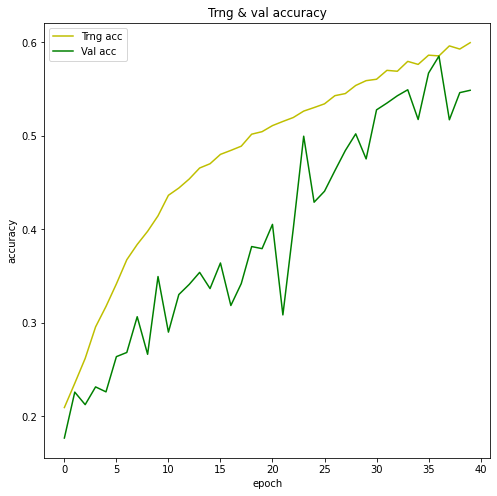

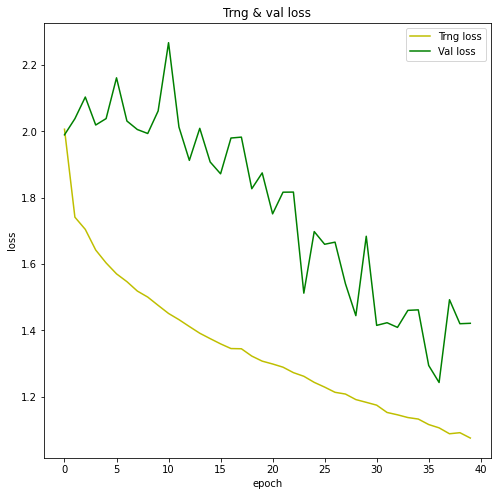

In [57]:
acuracy = history.history['accuracy']
val_acuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
n_epochs = range(len(acuracy))
plt.plot(n_epochs, acuracy, 'y', label='Trng acc')
plt.plot(n_epochs, val_acuracy, 'g', label='Val acc')
plt.title('Trng & val accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(n_epochs, loss, 'y', label='Trng loss')
plt.plot(n_epochs, val_loss, 'g', label='Val loss')
plt.title('Trng & val loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [58]:
trng_loss = model.evaluate(train_flow, steps=len(Xover) / 342) 
print("Train Loss " + str(trng_loss[0]))
print("Train Acc: " + str(trng_loss[1]))
val_loss = model.evaluate(val_flow, steps=len(Xval) / batch_size) 
print("Val Loss " + str(val_loss[0]))
print("Val Acc: " + str(val_loss[1]))
test_loss = model.evaluate(test_flow, steps=len(Xtest) / batch_size) 
print("Test Loss " + str(test_loss[0]))
print("Test Acc: " + str(test_loss[1]))

64/64 [==============================] - 4s 57ms/step - loss: 0.9950 - accuracy: 0.6293
Train Loss 0.9950072169303894
Train Acc: 0.6293269395828247
56/56 [==============================] - 3s 45ms/step - loss: 1.4212 - accuracy: 0.5492
Val Loss 1.4212239980697632
Val Acc: 0.5491780638694763
56/56 [==============================] - 3s 45ms/step - loss: 1.3595 - accuracy: 0.5617
Test Loss 1.359534740447998
Test Acc: 0.5617163777351379


In [59]:
def plt_con_mat(ytest, ypred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(ytest, ypred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)

    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

In [61]:
ypred_ = model.predict(Xtest/255., verbose=1)
ypred = np.argmax(ypred_, axis=1)
t_te = np.argmax(ytest, axis=1)

113/113 [==============================] - 3s 24ms/step


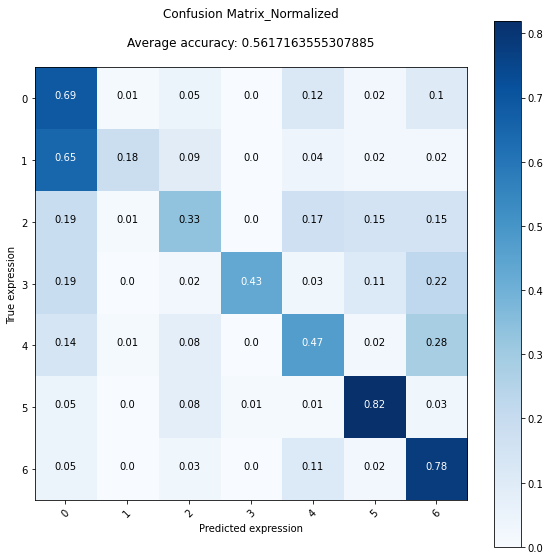

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
labels = np.array(("0", "1", "2", "3", "4", "5", "6"))

fig = plt_con_mat(ytest=t_te, ypred=ypred,
                      classes=labels,
                      normalize=True,
                      cmap=plt.cm.Blues,
                      title='Confusion Matrix_Normalized'+'\n\n'+'Average accuracy: ' + str(np.sum(ypred == t_te)/len(t_te)) + '\n')

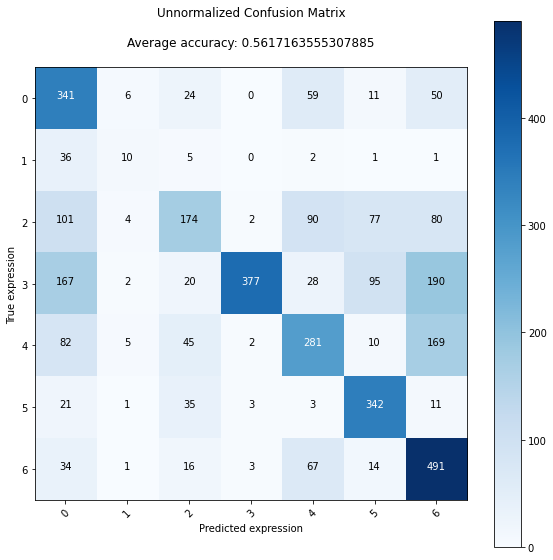

In [64]:
fig = plt_con_mat(ytest=t_te, ypred=ypred,
                      classes=labels,
                      normalize=False,
                      cmap=plt.cm.Blues,
                      title='Unnormalized Confusion Matrix'+'\n\n'+'Average accuracy: ' + str(np.sum(ypred == t_te)/len(t_te)) + '\n')

In [65]:
print(classification_report(t_te, ypred))

              precision    recall  f1-score   support

           0       0.44      0.69      0.54       491
           1       0.34      0.18      0.24        55
           2       0.55      0.33      0.41       528
           3       0.97      0.43      0.60       879
           4       0.53      0.47      0.50       594
           5       0.62      0.82      0.71       416
           6       0.49      0.78      0.61       626

    accuracy                           0.56      3589
   macro avg       0.56      0.53      0.51      3589
weighted avg       0.63      0.56      0.55      3589



In [68]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [69]:
IMAGE_SIZE = [224, 224]

In [70]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [71]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [75]:
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

NameError: ignored